# 使用預先訓練的卷積網絡(convnets)模型

注意: 這篇文章的內容需要一些Keras的理解, 這先確認你/妳己先閱讀並練習過以下的連結內容:
* [1.0-image-augmentation](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.0-image-augmentation.ipynb)
* [1.1-keras-functional-api](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.1-keras-functional-api.ipynb)
* [1.2-vgg16-from-scratch](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.2-vgg16-from-scratch.ipynb)
* [1.4-small-datasets-image-augmentation](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.4-small-datasets-image-augmentation.ipynb)


在小圖像數據集上進行深度學習的一種常見和高效的方法是利用預先訓練好的網絡模型。預先訓練好的網絡模型只是一個先前在大型數據集上訓練過後保存下來的網絡模型，通常是進行了大規模的圖像分類任務。

如果這個原始數據集足夠大且足夠普遍，那麼由訓練有素的網絡學習到的空間特徵層次可以有效地作為我們視覺世界的通用模型，因此其特徵可以證明對許多不同的電腦視覺問題是有用的，甚至儘管這些新問題可能涉及與原始任務完全不同的類型。

例如，可以在ImageNet上訓練一個網絡（其中圖像類別主要是動物和日常用品），然後重新使用這個訓練有素的網絡模型，以便識別圖像中的家具。與許多較舊的淺層學習方法相比，不同問題的學習特徵的這種可移植性是深度學習的一個主要優點，它使深度學習對於小數據圖像數據問題非常有效。

在我們的範例中，我們將使用在ImageNet數據集（140萬個標記的圖像和1000個不同的類別）上己經預訓練好的卷積網絡(convnets)模型。 ImageNet包含許多動物類別，包括不同種類的貓和狗，我們可以期望在我們的貓與狗分類問題上表現非常好。

我們將使用由克倫·西蒙尼（Karen Simonyan）和安德魯·齊斯曼（Andrew Zisserman）於2014年開發的VGG16架構，這是一種簡單而廣泛使用的ImageNet架構。雖然它是一個比較舊的模型(現在有許多更先進的卷積網絡模型)，同時VGG16也可能比其新近的模型還要肥重，但是我們選擇它是因為它的架構與你已經熟悉的類似，並且容易理解而且不需要引入任何新概念。

這可能是你第一次看到以下的名詞 -  VGG，ResNet，Inception，Inception-ResNet，Xception ...但你會習慣它們，因為如果你繼續深入學習電腦影像視覺的領域，它們會經常出現在你面前。

有兩種方法可以用來利用預先訓練的網絡模型：*特徵提取 (feature extraction)*和*微調(fine-tuning)*。我們將包括了這兩個層面。首先我們從特徵提取開始。

![transfer-learning](https://elearningindustry.com/wp-content/uploads/2016/09/5-tips-improve-knowledge-transfer-elearning-e1475138920743.jpeg)

In [1]:
# 這個Jupyter Notebook的環境
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

Using TensorFlow backend.


Platform: Windows-10-10.0.17134-SP0
Tensorflow version: 1.9.0
Keras version: 2.2.2


## 資料集說明

我們將使用的數據集(貓與狗的圖片集)沒有被包裝Keras包裝發佈, 因此要自行另外下載。Kaggle.com在2013年底提供了這些數據來作為電腦視覺競賽題目。您可以從以下連結下載原始數據集：`https://www.kaggle.com/c/dogs-vs-cats/data`

圖片是中等解析度的彩色JPEG檔。他們看起來像這樣：

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

該原始數據集包含25,000張狗和貓的圖像（每個類別12,500個），大小為543MB（壓縮）。下載和解壓縮後，我們將創建一個包含三個子集的新數據集：一組包含每個類的1000個樣本的訓練集，每組500個樣本的驗證集，最後一個包含每個類的500個樣本的測試集。

## 資料準備

1. 從[Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data)點擊`Download`下載圖像資料檔`training.zip`。
2. 在這個Jupyter Notebook所在的目錄下產生一個新的子目錄"data"。
3. 把從kaggle下載的資料檔複製到"data"的目錄裡頭。
4. 將`train.zip`解壓縮
  
最後你的目錄結構看起來像這樣:
```
xx-yyy.ipynb
data/
└── train/
    ├── cat.0.jpg
    ├── cat.1.jpg
    ├── ..
    └── dog.12499.jpg
```

In [2]:
import os

ROOT_DIR = os.getcwd()
DATA_PATH = "D:/Working Folder/packages/train"

In [3]:
import os
import shutil

base_dir = os.path.join(ROOT_DIR,"data/cats_and_dogs_small")
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    
train_dir = os.path.join(base_dir,"train")
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir,"validation")
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
    
test_dir = os.path.join(base_dir,"test")
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    
train_cats_dir = os.path.join(train_dir,"cats")
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)
    
train_dogs_dir = os.path.join(train_dir,"dogs")
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir,"cats")
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)
    
validation_dogs_dir = os.path.join(validation_dir,"dogs")
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)
    
test_cats_dir = os.path.join(test_dir,"cats")
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)
    
test_dogs_dir = os.path.join(test_dir,"dogs")
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)
    
fnames = ["cat.{}.jpg".format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(DATA_PATH,fname)
    dst = os.path.join(train_cats_dir,fname)
    if not os.path.exists(dst):
        shutil.copyfile(src,dst)
print("Copy fisrt 1000 cat images to train_cats_dit complete!")

fnames = ["cat.{}.jpg".format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(DATA_PATH,fname)
    dst = os.path.join(validation_cats_dir,fname)
    if not os.path.exists(dst):
        shutil.copyfile(src,dst)
print("Copy fisrt 500 cat images to validation_cats_dit complete!")

fnames = ["cat.{}.jpg".format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(DATA_PATH,fname)
    dst = os.path.join(test_cats_dir,fname)
    if not os.path.exists(dst):
        shutil.copyfile(src,dst)
print("Copy fisrt 500 cat images to test_cats_dit complete!")


fnames = ["dog.{}.jpg".format(i) for i in range(0,1000)]
for fname in fnames:
    src = os.path.join(DATA_PATH,fname)
    dst = os.path.join(train_dogs_dir,fname)
    if not os.path.exists(dst):
        shutil.copyfile(src,dst)
print("Copy fisrt 1000 dog images to train_dogs_dit complete!")

fnames = ["dog.{}.jpg".format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(DATA_PATH,fname)
    dst = os.path.join(validation_dogs_dir,fname)
    if not os.path.exists(dst):
        shutil.copyfile(src,dst)
print("Copy fisrt 500 dog images to validation_dogs_dit complete!")

fnames = ["dog.{}.jpg".format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(DATA_PATH,fname)
    dst = os.path.join(test_dogs_dir,fname)
    if not os.path.exists(dst):
        shutil.copyfile(src,dst)
print("Copy fisrt 500 dog images to test_dogs_dit complete!")

Copy fisrt 1000 cat images to train_cats_dit complete!
Copy fisrt 500 cat images to validation_cats_dit complete!
Copy fisrt 500 cat images to test_cats_dit complete!
Copy fisrt 1000 dog images to train_dogs_dit complete!
Copy fisrt 500 dog images to validation_dogs_dit complete!
Copy fisrt 500 dog images to test_dogs_dit complete!


作為一個健康檢查，讓我們計算每次訓練分組中有多少張照片（訓練/驗證/測試）:

In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


所以我們確實有2000個訓練圖像，然後是1000個驗證圖像和1000個測試圖像。在每個資料分割(split)中，每個分類都有相同數量的樣本：這是一個平衡的二元分類問題，這意味著分類準確度將成為適當的度量。

# 特徵提取 (feature extraction)

特徵提取包括了使用預訓練好的網絡模型來從新樣本中提取特徵。這些特徵通過一個"新"的分類器(從頭開始訓練)。

如前所述，用於圖像分類的卷積網絡(convnets)架構包括了兩大部分：它們以一系列卷積和池化層開始，並且以密集連接(densely-connected)的分類器結束。第一部分稱為模型的“卷積基底”。在卷積網絡裡，“特徵提取”將簡單地包括先前訓練過的網絡的“卷積基底”，通過它重新餵入新的數據，並且根據這個“卷積基底”的輸出之後再接續訓練一個新的分類器。

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)


為什麼只重用“卷積基底”? 我們可以重用密集連接(densely-connected)的分類器嗎? 一般來說，應該避免。原因是簡單地說，“卷積基底”學習的特徵可能是更通用的，因此更可重複使用：一個卷積網絡的特徵圖(feature maps)是一個通用概念對應到圖片的映射。 另一方面，由分類器學習的特徵將非常特定於模型被訓練的類別的集合 - 它們將僅包含關於整個圖片中該類或該類的存在機率的訊息。

此外，在密集連接的層中發現的表示(representation)不再包含有關"空間/位置"位於輸入圖像中的任何信息：這些層己經擺脫了空間的概念。對於物件位置重要且敏感的問題，密集連接層的功能將在很大程度上是無法重覆利用的。

注意，由特定卷積層提取的表示(representation)的一般性（因此可重用性）的級別取決於模型中神經層的深度。在模型中較早的層提取局部，高度通用的特徵圖（如視覺邊緣，顏色和紋理），而較高層則提取更多的抽象概念（如“貓耳朵”或“狗眼”）。因此，如果您的新數據集與原始模型被訓練的數據集有很大的不同，那麼您最好只使用模型的前幾個層進行特徵提取，而不是使用整個“卷積基底”。


在我們的範例中，由於ImageNet類集合包含多個dog和cat類，所以重用包含在原始模型密集連接層中的信息很有可能是有益的。但是，為了覆蓋更多的一般情況，我們將不會選擇使用原始模型密集連接層, 因為新的問題的類別集與原始模型的類別集並沒有重疊。

讓我們通過使用在ImageNet上訓練的VGG16網絡的“卷積基底”來應用在我們的貓和狗圖像中提取特徵，然後在這些特徵之上訓練一個貓與狗分類器。

VGG16模型與Keras己經預先包裝在一起分佈。你可以從`keras.applications`模組導入。以下是可用作`keras.applications`一部分的圖像分類預訓練的模型列表（均在ImageNet數據集上預先訓練過了）:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

我們來實例化一個VGG16模型：

In [5]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, # 在這裡告訴 keras我們只需要卷積基底的權重模型資訊
                  input_shape=(150, 150, 3)) # 宣告我們要處理的圖像大小與顏色通道數

我們向構造函數傳遞了三個參數：

* `weights`, 指定從哪個權重檢查點從中初始化模型
* `include_top`, 這是指在網絡頂部要包括或不包含密集連接的分類器。默認情況下，這個密集連接的分類器將對應於ImageNet的1000個類別。因為我們打算用自己建構的分類器（只有兩個類別，貓和狗），因此我們不需要包括它。
* `input_shape`, 我們將餵進到網絡的圖像張量的形狀(shape)。這個參數純粹是可選的：如果我們設定，那麼網絡將能夠處理任何大小的輸入。

以下是VGG16“卷積基底”架構的細節：它與您已經熟悉的簡單卷積網絡(convnets)非常相似。

In [6]:
conv_base.summary() # 打印一下模型資訊

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

最後的特徵圖具有形狀`（4，4，512）`。這是我們將連結到自己的密集連結(densely-connected)分類器的輪入張量。

在這節骨眼上，我們有兩種方法可以進行：

1 在我們的數據集上運行“卷積基底”，將其輸出以Numpy陣列的型式記錄到磁盤上，然後將此數據作為獨立密集分類器(densely-connected classifier)的輸入。這種解決方案非常快速且簡單，因為它只需要為每個輸入圖像運行一次的“卷積基底”，而“卷積基底”是迄今為止管道中最昂貴的部分。然而，由於基於相同的原因，這種作法也不能讓我們去使用數據增加(data augmentation)的手法。

2 通過在己經訓練好的模型頂端繼續添加`Dense`層，擴展我們擁有的模型（`conv_base`），並在輸入數據上端對端地運行整個數據的輪入。這樣的作法允許我們使用數據增加(data augmentation)，因為每次輸入圖像每次被模型看到時都會經過“卷積基底”。然而，這種技術比第一種技術要花更多的計算與訓練時間。

我們將涵蓋這兩種技術的做法。

## 方法1: 卷積基底:提取特徴 + 串接新的密集分類層:重新訓練

我們來看看設置第一種方法所需的程式碼：在我們的數據上記錄“conv_base”的輸出，並使用這些輸出作為新模型的輸入。

我們將首先簡單地運行以前介紹的“ImageDataGenerator”的實例，以將圖像提取為Numpy數組及其標籤。我們將通過調用`conv_base`模型的`predict`方法從這些圖像中提取特徵。

### 移花

In [7]:
##特徵提取

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# base_dir = 'data/5_1/cats_and_dogs_small'
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255) # 產生一個"圖像資料產生器"物件

batch_size = 20 # 設定每次產生的圖像的數據批量

# 提取圖像特徵
def extract_features(directory, sample_count): # 影像的目錄, 要處理的圖像數
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # 根據VGG16(卷積基底)的最後一層的輪出張量規格
    labels = np.zeros(shape=(sample_count)) # 要處理的圖像數
    
    # 產生一個"圖像資料產生器"實例(資料是在檔案目錄中), 每呼叫它一次, 它會吐出特定批次數的圖像資料
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),  # 設定圖像的高(height)與寬(width)
        batch_size=batch_size,   # 設定每次產生的圖像的數據批量
        class_mode='binary')     # 因為我們的目標資料集只有兩類(cat & dog)
    
    # 讓我們把訓練資料集所有的圖像都跑過一次
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) # 透過“卷積基底”來淬取圖像特徵
        features[i * batch_size : (i + 1) * batch_size] = features_batch # 把特徴先存放起來
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch #把標籤先存放起來
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    
    print('extract_features complete!')
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000) # 訓練資料的圖像特徵淬取
validation_features, validation_labels = extract_features(validation_dir, 1000) # 驗證資料的圖像特徵淬取
test_features, test_labels = extract_features(test_dir, 1000) # 測試資料的圖像特徵淬取

Found 2000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!
Found 1000 images belonging to 2 classes.
extract_features complete!


提取的特徵當前是`（樣本數，4，4，512）`的形狀。我們將它們餵給一個密集連接(densely-connected)的分類器，所以首先我們必須把它們壓扁(flatten)成`（樣本數, 8192）`:

In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### 接木

在這個時間點上，我們可以定義我們密集連接(densely-connected)的分類器（注意使用dropout來進行正規化），並對我們剛剛記錄的數據和標籤進行訓練：

In [9]:
from keras import models
from keras import layers
from keras import optimizers

# 產生一個新的密集連接層來做為分類器
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) # 因為我的資料集只有兩類(cat & dog)

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# 把透過預處理的卷積基底所提取的特徵做為input來進行訓練
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5859 - acc: 0.6790 - val_loss: 0.4458 - val_acc: 0.8340
Epoch 2/30
2000/2000 [==============================] - 2s 938us/step - loss: 0.4308 - acc: 0.8010 - val_loss: 0.3607 - val_acc: 0.8790
Epoch 3/30
2000/2000 [==============================] - 2s 907us/step - loss: 0.3558 - acc: 0.8575 - val_loss: 0.3234 - val_acc: 0.8850
Epoch 4/30
2000/2000 [==============================] - 2s 912us/step - loss: 0.3197 - acc: 0.8665 - val_loss: 0.3004 - val_acc: 0.8910
Epoch 5/30
2000/2000 [==============================] - 2s 919us/step - loss: 0.2818 - acc: 0.8840 - val_loss: 0.2806 - val_acc: 0.8980
Epoch 6/30
2000/2000 [==============================] - 2s 913us/step - loss: 0.2666 - acc: 0.8890 - val_loss: 0.2720 - val_acc: 0.9000
Epoch 7/30
2000/2000 [==============================] - 2s 908us/step - loss: 0.2492 - acc: 0.8945 - val_loss: 0.2621 - val_acc: 0.9010
Ep

訓練非常快，因為我們只需要處理兩個`Dense`層：即使在CPU上，每個訓練循環(epoch)也需要不到一秒的時間。

讓我們來看看訓練過程中的損失(loss)和精準度(accuracy):

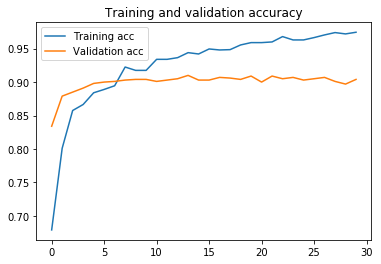

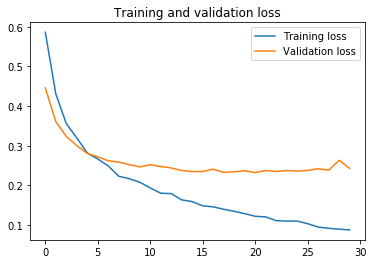

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

我們的驗證準確率達到了90%左右，遠遠優於[1.4-small-datasets-image-augmentation](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/1.4-small-datasets-image-augmentation.ipynb)那個從頭開始訓練起的小型模型。然而，我們的圖表也也表明，我們幾乎從一開始就過度擬合(overfitting)了，儘管我們使用了相當大的Dropout。

這是因為這種技術不需用到數據擴充(對於防止用小圖像數據集過度擬合是很重要的)。

## 方法2: (卷積基底:凍結 + 串接新的密集分類層) >> 重新訓練

現在，我們來回顧一下我們提到的第二種特徵提取技術，這種方法要慢得多，而且會花更多的時間與計算資源，但是我們可以在訓練過程中利用數據擴充(data augmentation): 擴展`conv_base`模型，並進行端(end)對端(end)的訓練。

請注意，這種手法真的是非常昂貴的，所以只有在你有GPU時才應該嘗試它：在CPU上是絕對棘手的。如果您無法在GPU上運行代碼，那麼前一個手法就是你要選的路。

因為模型的行為就像堆積木，所以你可以添加一個模型（像我們的`conv_base`）到`Sequential`模型，就像添加一個圖層一樣。所以你可以執行以下操作：

### 移花+接木

In [11]:
from keras import models
from keras import layers

model = models.Sequential() # 產生一個新的網絡模型結構
model.add(conv_base)        # 把預訓練的卷積基底疊上去
model.add(layers.Flatten()) # 打平
model.add(layers.Dense(256, activation='relu'))  # 疊上新的密集連接層來做為分類器
model.add(layers.Dense(1, activation='sigmoid')) # 因為我的資料集只有兩類(cat & dog)

這是我們現在的模型：

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


如您所見，VGG16的“卷積基底”有14,714,688個參數，這非常大。我們上面添加的分類器有200萬個參數。

在編譯和訓練我們的模型之前，一個非常重要的事情是凍結“卷積基底”。 “凍結”一層或多層圖層意味著在訓練期間防止其權重被更新。如果我們不這樣做，那麼以前在“卷積基底”上學到的特徵將在訓練期間被修改。由於頂層的`Dense`層會被隨機初始化，因此非常大的權重更新將通過網絡重新進行傳播， 也會破壞以前學習的結果。

在Keras中，通過將它的`trainable`屬性設置為`False`來凍結網絡:

In [13]:
# 看一下“凍結前”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [14]:
# “凍結”卷積基底
conv_base.trainable = False

In [15]:
# 再看一下“凍結後”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


通過這種設置，只有來自我們添加的兩個`Dense`層的權重將被訓練。這是總共有四個權重的張量：每層兩個（主要權重矩陣和偏差向量）。請注意，為了使這些更改生效，我們必須首先編譯模型。

如果您在編譯後修改了權重可訓練性，那麼應該重新編譯模型，否則這些更改將被忽略。

現在我們可以開始訓練我們的模型，使用與我們前面的例子中使用相同的數據增強配置：

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 請注意: 驗證用的資料不要進行資料的增強
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料的目錄
        train_dir,
        # 設定圖像的高(height)與寬(width)
        target_size=(150, 150),
        batch_size=20,
        # 因為我們的目標資料集只有兩類(cat & dog)
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 73s - loss: 0.5966 - acc: 0.6865 - val_loss: 0.4622 - val_acc: 0.8160
Epoch 2/30
 - 72s - loss: 0.4828 - acc: 0.7725 - val_loss: 0.3663 - val_acc: 0.8650
Epoch 3/30
 - 72s - loss: 0.4354 - acc: 0.8125 - val_loss: 0.3249 - val_acc: 0.8740
Epoch 4/30
 - 72s - loss: 0.3932 - acc: 0.8265 - val_loss: 0.3005 - val_acc: 0.8870
Epoch 5/30
 - 72s - loss: 0.3809 - acc: 0.8380 - val_loss: 0.2951 - val_acc: 0.8790
Epoch 6/30
 - 72s - loss: 0.3678 - acc: 0.8395 - val_loss: 0.2791 - val_acc: 0.8880
Epoch 7/30
 - 72s - loss: 0.3511 - acc: 0.8525 - val_loss: 0.2744 - val_acc: 0.8980
Epoch 8/30


In [ ]:
model.save('cats_and_dogs_small_3.h5') # 把模型儲存到檔案

我們再來看一次我們的結果：

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

如您所見，我們的驗證準確率達到了96％。這比我們從頭開始訓練的小型卷積網絡(convnets)要更好。

# 微調 (fine-tuning)

另一種廣泛使用的模型重覆利用技術，與_特徵提取(feature extraction)_相輔相成，是 _(微調) fine-tuning_。

微調包括解凍用於特徵提取的凍結模型庫中的幾個頂層(top layers)，並且共同訓練新添加的模型部分（在我們的範例中是完全連接的分類器）和這些頂層。這被稱為“微調(fine-tuning)”，因為它稍微調整正在重複使用的模型中更抽象的表示，以使它們與當前的要處理的問題更相關。

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

之前我們已經說過，必須凍結VGG16的“卷積基底”，才能在上面訓練一個隨機初始化的分類器。出於同樣的原因，一旦分類器已經被訓練，只能微調“卷積基底”的頂層。如果分類尚未被訓練，則在訓練期間通過網絡傳播的誤差信號將會變得太大，並且被微調那些神經層先前學習的表示(representation)將被破壞。因此，微調網絡的步驟如下：

1. 將自定義網絡添加到已經訓練好的基底網絡之上。
2. 凍結基底網絡。
3. 訓練您添加的部分。
4. 解凍基底網絡中的一些神經層。
5. 共同訓練這些層和您添加的部分。

在進行特徵提取時，我們已經完成了前3個步驟。我們繼續第四步：我們將解凍我們的`conv_base`，然後凍結其中的某些特定的層。

作為一個提醒，這是我們的“卷積基底”看起來的樣貌：

In [ ]:
conv_base.summary()

我們將微調(fine-tuning)最後3個卷積層，這意味著所有層直到`block4_pool`都應該被凍結，而`block5_conv1`，`block5_conv2`和`block5_conv3`的層應該是可訓練的。

為什麼不調整更多層? 為什麼不調整整個“卷積基底”? 我們可以。但是，我們需要考慮：

* “卷積基底”中較前面的神經層所學習到的特徵表示更加通用(generic)，更具有可重複使用的特徵，而較高層次的特徵表示則聚焦獨特的特徵。微調這些聚焦獨特的特徵的神經層則更為有用，因為這些功能是需要重新被訓練來解決我們的新問題。微調愈底層則從既有預訓練模型所得到的回報會愈少。

* 我們訓練的參數越多，我們越有可能的過擬合(overfitting)。VGG16的“卷積基底”具有1千5百萬的參數，因此嘗試在小數據集上進行訓練是有風險的。

因此，在這樣的情況下，只有在“卷積基底”中微調頂部2到3層是一個很好的策略。

讓我們設定一下，從上一個例子中我們離開的地方開始：

In [ ]:
conv_base.trainable = True # 解凍 "卷積基底"

# 所有層直到block4_pool都應該被凍結，而 block5_conv1，block5_conv2, block5_conv3 及 block5_pool則被解凍        
layers_frozen = ['block5_conv1','block5_conv2', 'block5_conv3', 'block5_pool']
for layer in conv_base.layers:
    if layer.name in layers_frozen:
        layer.trainable = True
    else:
        layer.trainable = False
        
# 把每一層是否可以被"trainable"的flat打印出來
for layer in conv_base.layers:
    print("{}: {}".format(layer.name, layer.trainable))        


現在我們可以開始微調我們的網絡。我們將使用非常低的學習率(learning rate)來使用RMSprop優化器。使用低學習率的原因是我們希望限制我們對我們進行微調的3個卷積層表示(representation)所做的修改的大小幅度。太大的更新可能會損害這些表示(representations)。

現在我們開始微調：

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # 使用小的learn rate
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

In [ ]:
model.save('cats_and_dogs_small_4.h5')

我們使用相同的繪圖代碼繪製我們的結果：

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

這些曲線看起來有很多的雜訊。為了使它們更易於閱讀，我們可以通過以這些數量的指數移動平均值代替每個損失和準確性來平滑它們。這是一個簡單的工具函數：

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

這些曲線看起來更清潔，更穩定。我們看到一個很好的1%的改善。

請注意，損失曲線沒有顯示任何實際的改善（實際上它正在惡化）。你可能會想，如果損失不減少，準確性如何提高？答案很簡單：我們顯示的是一個平均值的點損失值，但實際上對於精度來說重要的是損失值的分佈，而不是它們的平均值，因為精度是由模型。即使這並不反映在平均損失中，該模型仍然有繼續改善的空間。

我們現在可以在測試數據上最終評估這個模型：

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

這裡我們的測試精確度為97%。在這個數據集的原始Kaggle比賽中，這將取得非常高的排名。

然而，使用現代深度學習技術，我們僅使用一部分的訓練數據（約10%）就可以達到此種結果。能夠訓練20,000個樣本資料，而不是2000個樣本資料，有非常巨大的差異!

## 總結

* 卷積網絡(convnets)是目前電腦視覺運算法中最好的機器學習模型。即使在非常小的數據集上，也可以從頭開始訓練一個，具有不錯效果的模型。
* 在一個小數據集上，過度擬合(overfitting)將成為主要問題。數據增加(data augmentation)是處理圖像數據時打擊過擬合的有效方式。
* 通過特徵提取(feature extraction)，可以輕鬆地在新數據集上重用覆用現有的預先訓練卷積網絡(convnets)模型。這是解決小圖像數據集非常有價值的技術。
* 作為特徵提取(feature extraction)的補充，可以使用微調(fine-tuning)，它可以調整現有模型去學習新問題的一些表示特徵。這會進一步推動預測性能。

現在，您有一整套處理圖像分類問題的工具，特別是使用小數據集。

參考: 
* [fchollet: deep-learning-with-python-notebooks (原文)](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)
* [Keras官網](http://keras.io/)

MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.